# Module 3 Final Project

In [1]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(6218)

#set graphing preferences
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')
%matplotlib inline

from sklearn.metrics import roc_curve, auc, accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE


# Obtain

The data I will be using for this project is a dataset that is maintained by [UCI](//archive.ics.uci.edu/ml/datasets/bank+marketing#). 

**For this project, my goal will be to create a model using the data to predict whether or not a customer will subscribe to Term Deposit.**

In [2]:
#load DataFrame
raw_df=pd.read_csv('bank_customer_survey.csv')
raw_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0


In [3]:
#check feat datatypes
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null int64
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [4]:
#describe numerical data
raw_df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [5]:
#check for null values
raw_df.isna().any().any()

False

Detailed notes about features in the datatset:

- **age**: *[numerical]*
- **job**: *[categorical]* 12 values 
- **marital**: *[categorical]* 3 values - single, married, divorced
- **education**: *[categorical]* 4 values - primary, secondary, tertiary, unknown
- **default**: *[categorical]* 2 values - yes,no 
- **balance**: *[numerical]*
- **housing**: *[categorical]* 2 types - yes,no 
- **loan**: *[categorical]* 2 types - yes,no 
- **contact**: *[categorical]*
- **day**: *[numerical]* 
- **month**: *[categorical]*
- **duration**: *[numerical]*
- **campaign**: *[numerical]*
- **pdays**: *[numerical]*
- **previous**: *[numerical]*
- **poutcome**: *[categorical]*
- **y**: *[numerical]*

# Scrub

In [6]:
#create feature dataframe without target
feat = raw_df.drop(['duration','y'],axis=1)
feat.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown


In [7]:
# convert default, housing and loan to binary coding
binary_feats=['default','housing','loan']
for binary_feat in binary_feats:
    feat[binary_feat]=feat[binary_feat].map({'no':0,'yes':1})
feat.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown


In [8]:
#one-hot encoding for categorical data
one_hot_feat=pd.get_dummies(feat)
one_hot_feat.head(3)

,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [9]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot_feat)

scaled_feat = pd.DataFrame(scaled_data, columns=one_hot_feat.columns)
scaled_feat.head(3)

,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,-0.13549,0.256419,0.893915,-0.436803,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519
1,0.288529,-0.13549,-0.437895,0.893915,-0.436803,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519
2,-0.747384,-0.13549,-0.446762,0.893915,2.289359,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519


In [ ]:
raw_df['y'].value_counts()

# Explore

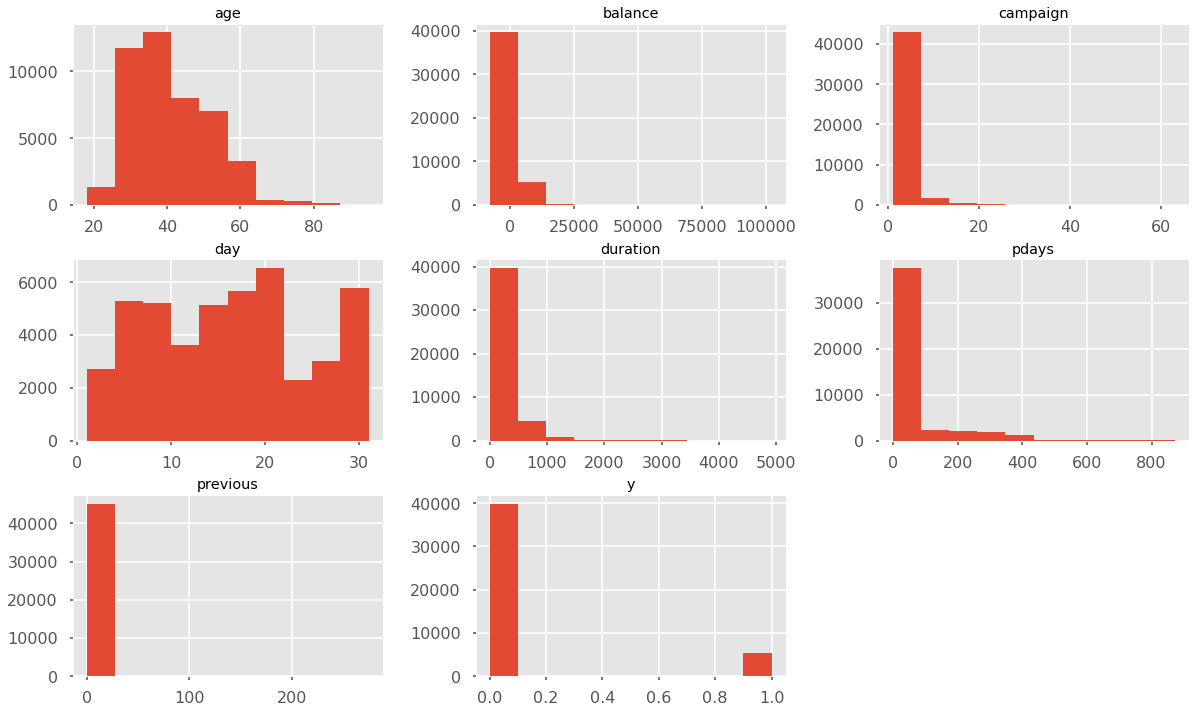

In [10]:
raw_df.hist(figsize=(20,12));

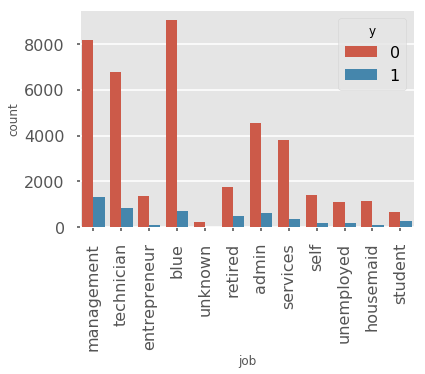

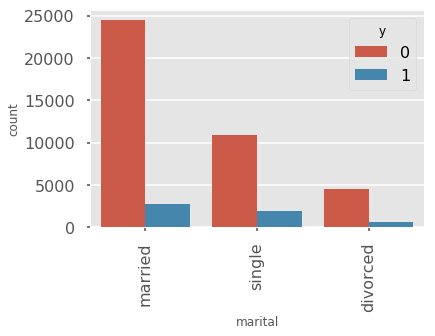

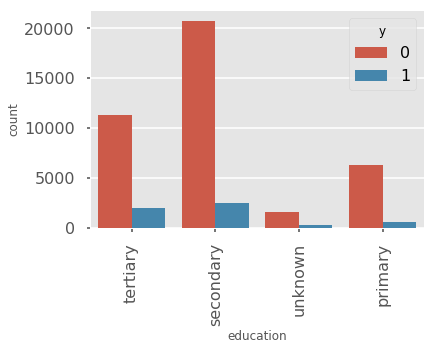

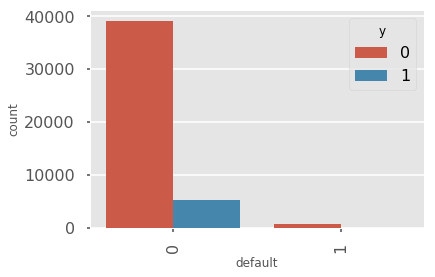

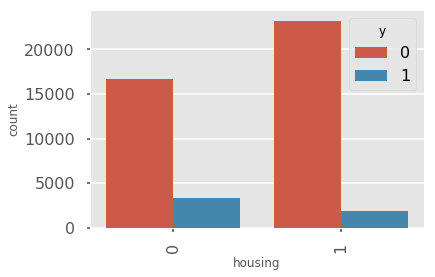

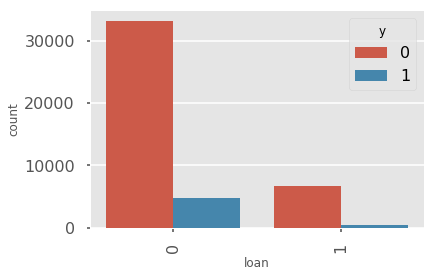

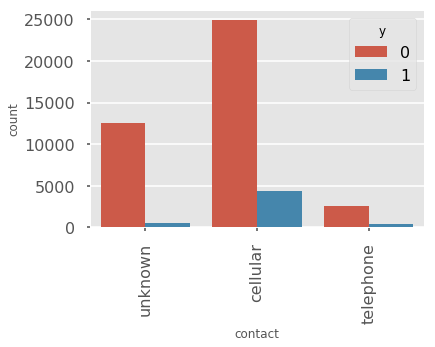

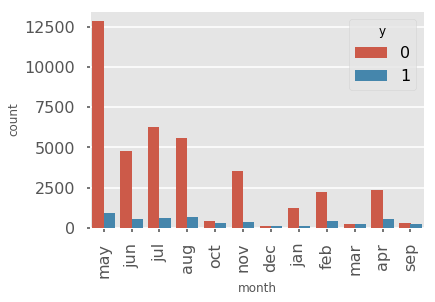

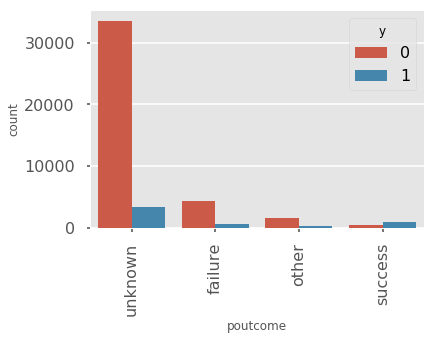

In [11]:
for index,column in enumerate(raw_df.select_dtypes(include='object')):
    sns.countplot(feat[column],hue=raw_df['y'],data=raw_df)
    plt.xticks(rotation=90)
    plt.show()

# Model

## Initial Basic Model Using XGBoost

In [15]:
#create variables
X=scaled_feat
y=raw_df['y']
#split data for modeling
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

clf_dt=tree.DecisionTreeClassifier()
clf_lr=LogisticRegression()
clf_rf=RandomForestClassifier()
clf_svm=svm.SVC()
clf_xgb=xgb.XGBClassifier()

classifiers=[clf_xgb,clf_dt,clf_lr,clf_rf,clf_svm]
names=['XGBoost','Decision Tree','Logistic Regression',
       'Random Forest','Support Vector Machine']

for index , clf in enumerate(classifiers):
    clf.fit(X_train,y_train)
    print('{} basic model accuracy score {:.4}%'.format(names[index],clf.score(X_test,y_test)*100))
    print('{} basic model F1 score {:.4}'.format(names[index],f1_score(y_test,clf.predict(X_test))))
    print('\n')
    

XGBoost basic model accuracy score 89.33%
XGBoost basic model F1 score 0.2696


Decision Tree basic model accuracy score 83.24%
Decision Tree basic model F1 score 0.3081


Logistic Regression basic model accuracy score 89.32%
Logistic Regression basic model F1 score 0.2657


Random Forest basic model accuracy score 88.96%
Random Forest basic model F1 score 0.2921


Support Vector Machine basic model accuracy score 89.41%
Support Vector Machine basic model F1 score 0.2968




Based on these initial models, I am interested in finding out more information on the XGBoost, which is a very powerful model, with high accuracy and much quicker than the SVM model. I am also interested in the Random Forest model as it has a high F1 score as well as accuracy score.

In [35]:
#create predicitons basesd on training and testing data
rf_training_preds = clf_rf.predict(X_train)
rf_testing_preds = clf_rf.predict(X_test)

xgb_training_preds = clf_xgb.predict(X_train)
xgb_testing_preds = clf_xgb.predict(X_test)

In [36]:
#define function to show accuracy and f1 scores and confusion matrix
def test_model_performance(y,preds,model):
    print('{} Performance'.format(model))
    print('--------------')
    
    #print accuracy score as percentage
    print("Accuracy: {:.4}%".format(
        accuracy_score(y,preds) * 100))
    
    #print AUC
    fpr, tpr, thresholds = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    print("AUC is: {:.2}".format(roc_auc))
    
    #f1_score
    print("F1: {:.4}".format(
        f1_score(y,preds)))
    
    #create and plot confusion matrix
    cnf_matrix = confusion_matrix(y,preds)
    plot_confusion_matrix(cnf_matrix)

    

#define function to plot confusion matrix
def plot_confusion_matrix(cnf_matrix):
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.
    sns.set_style("dark")
    
    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()

Random Forest Training Performance
--------------
Accuracy: 98.57%
AUC is: 0.94
F1: 0.9357


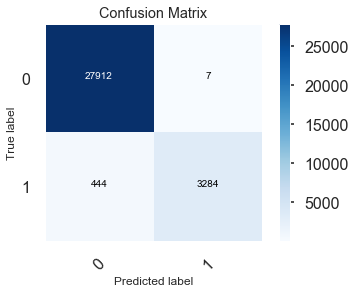

Random Forest Testing Performance
--------------
Accuracy: 88.96%
AUC is: 0.59
F1: 0.2921


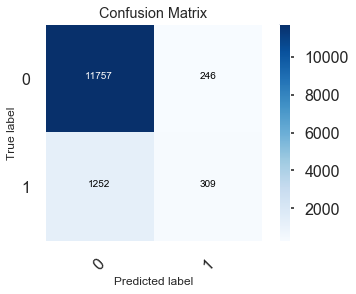

XGboost Training Performance
--------------
Accuracy: 89.74%
AUC is: 0.6
F1: 0.3242


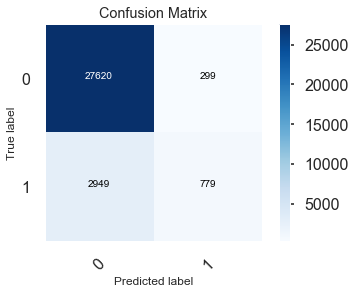

XGboost Testing Performance
--------------
Accuracy: 89.33%
AUC is: 0.58
F1: 0.2696


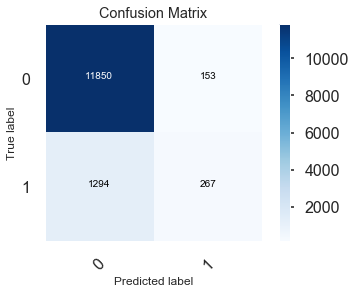

In [37]:
test_model_performance(y_train,rf_training_preds,'Random Forest Training')
test_model_performance(y_test,rf_testing_preds,'Random Forest Testing')

test_model_performance(y_train,xgb_training_preds,'XGboost Training')
test_model_performance(y_test,xgb_testing_preds,'XGboost Testing')

Based on the perfomance of this basic model, we have some tuning to do. Some of the issues that I see with this model is that we have a very imbalanced dataset in terms of classifiers. This can be seen by simply printing the value_counts of the target data but can be confirmed through this first model. Because of this, we want to focus on the F1 score of our dataset as the F1 score is a measurement of the balance between precision and recall. 

We have a high accuracy score but we have a low F1 score, meaning we need to focus on balancing and improving our model. 

My plan to improve my model is to:

1. Balance my training data using SMOTE
    - Retrain our classifier
2. Determine the final algorith
    - Use GridSearchCV to tune the parameters
3. Re-evaluate

### 1. Balance using SMOTE

In [38]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts())#Preview synthetic sample class distribution

#change to DataFrame from array
X_train_resampled=pd.DataFrame(X_train_resampled,columns=X_train.columns)

0    27919
1     3728
Name: y, dtype: int64
1    27919
0    27919
dtype: int64


Random Forest Training Performance
--------------
Accuracy: 99.6%
AUC is: 1.0
F1: 0.996


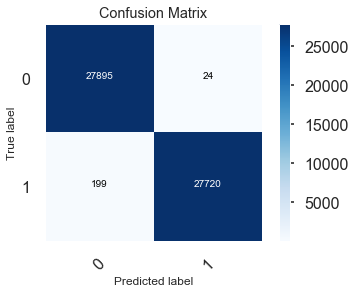

Random Forest Testing Performance
--------------
Accuracy: 87.59%
AUC is: 0.62
F1: 0.3479


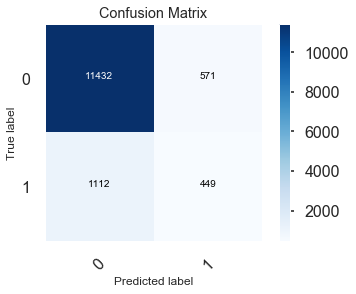

XGboost Training Performance
--------------
Accuracy: 88.99%
AUC is: 0.89
F1: 0.8834


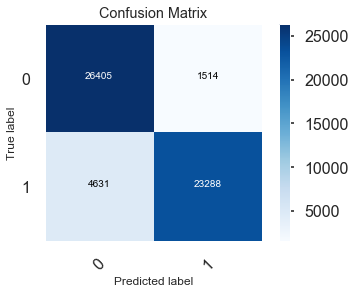

XGboost Testing Performance
--------------
Accuracy: 87.86%
AUC is: 0.65
F1: 0.4035


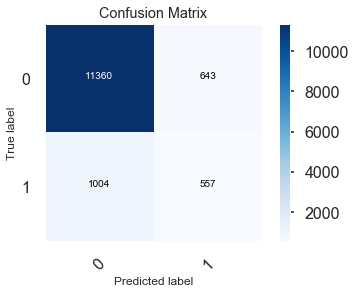

In [39]:
#use XGboost for modeling
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train_resampled, y_train_resampled)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_resampled, y_train_resampled)


#create predicitons basesd on training and testing data

rf_training_preds = clf_rf.predict(X_train_resampled)
rf_testing_preds = clf_rf.predict(X_test)

xgb_training_preds = clf_xgb.predict(X_train_resampled)
xgb_testing_preds = clf_xgb.predict(X_test)

#perform our analysis on performance
test_model_performance(y_train_resampled,rf_training_preds,'Random Forest Training')
test_model_performance(y_test,rf_testing_preds,'Random Forest Testing')

test_model_performance(y_train_resampled,xgb_training_preds,'XGboost Training')
test_model_performance(y_test,xgb_testing_preds,'XGboost Testing')

Resampling has greatly improved our training F1 score for both the Random Forest as well as the XGBoost models. Based on this data, it seems that the XGBoost model performs slightly better on the testing data and therefore I will use this algorith for tuning purposes. 

In [ ]:
param_grid = {
    'max_depth': [4,5,6],
    'n_estimators': [50, 100, 350, 500, 1000],
}

grid_clf = GridSearchCV(clf_xgb, param_grid, scoring='f1', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

XGBoost resampled Performance
--------------
Accuracy: 94.82%
AUC is: 0.95
F1: 0.9464


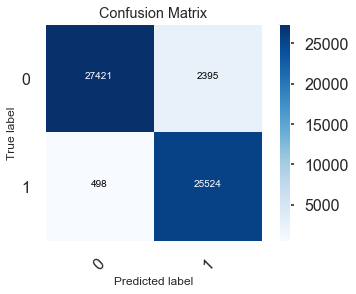

XGBoost test resampled Performance
--------------
Accuracy: 89.33%
AUC is: 0.74
F1: 0.3798


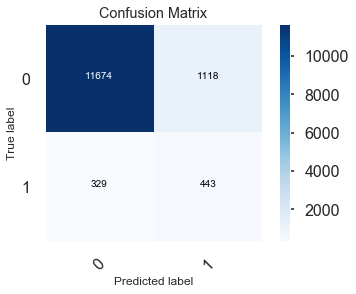

In [22]:
#create predicitons basesd on training and testing data
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

In [ ]:
param_grid = {
    'gamma':[i/10.0 for i in range(0,5)],
    'learning_rate': [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample':[i/10.0 for i in range(6,10)],
    'n_estimators': [],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='f1', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
#create predicitons basesd on training and testing data
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

In [ ]:
param_grid = {
    'gamma':[0.0],
    'learning_rate': [0.1],
    'max_depth': [6],
    'min_child_weight': [4,6,8,10,12],
    'subsample':[0.9],
    'n_estimators': [350],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='f1', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
#create predicitons basesd on training and testing data
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

gamma: 0.0
learning_rate: 0.1
max_depth: 6
min_child_weight: 6
n_estimators: 350
subsample: 0.9

# Interpret

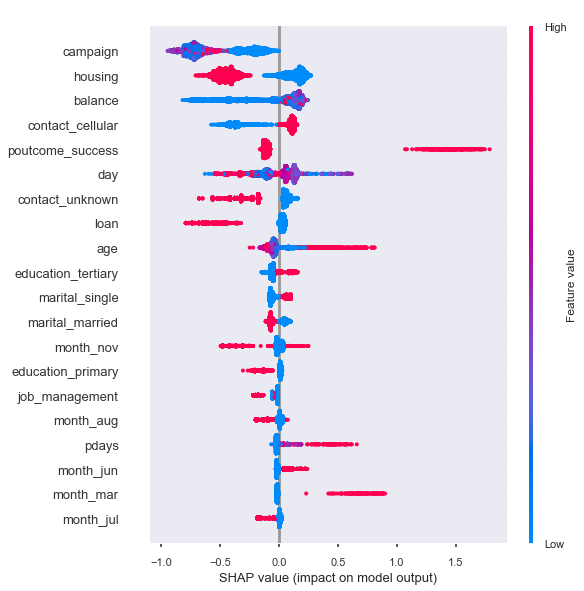

In [24]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)